# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import set_config, linear_model
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy as sp

## Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

I opened the spreadsheet and scrolled down to get a general feel for the data. I looked at the categories and began
to think about their relevance and utility. Right off the bat, it is very apparent that there are a large number of
empty cells, so I will need to drop columns. Here is how I made those decisions:

1. I decided that regional data will not be helpful. Dealerships generally do not have profit margins high enough
   to purchase vehicles from far away, so they will have relatively little ability to select vehicles based on 
   regional data.
2. Included identifiers may be dropped, as that data is captured in the index
3. Columns that have categorical responses with a large number of categories can also be dropped, as they are not
   easy to encode, and large numbers of categories with relatively few entries are not useful for extracting patterns

## Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

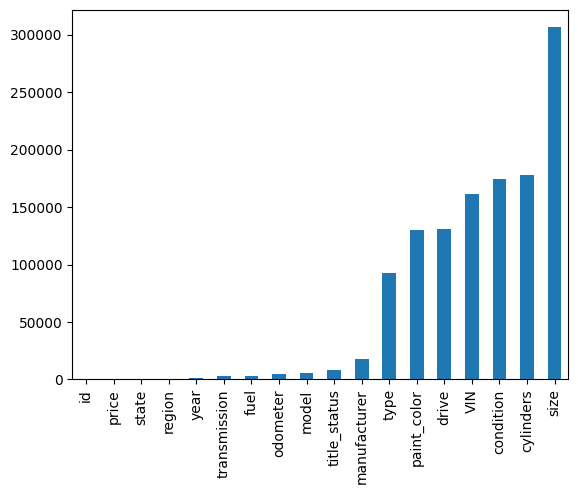

In [48]:
# Import the raw data
cars = pd.read_csv('data/vehicles_full.csv')

#  I see a lot of empty cells so I ran this script:

cars.isnull().sum().sort_values().plot(kind = 'bar')
plt.show();

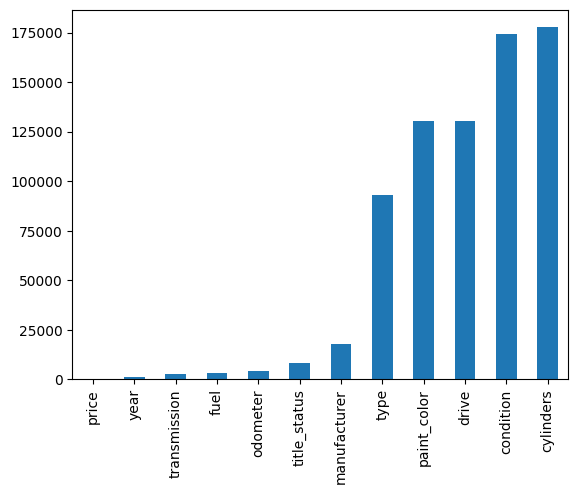

In [49]:
# I will drop 'state' first because it has too many missing values

# I then dropped the following columns because they do not provide useful data:
# 'id', 'VIN'

# Finally, I used 

####     print(cars['region'].value_counts())    ####

# to examine the columns to see how many categories were in each.
# 'region', 'model', and 'state' have a large number of categories
# so it is hard to encode them, so I dropped them as well

cars = cars.drop(['id','region','model','VIN','size','state'],axis=1)
cars.isnull().sum().sort_values().plot(kind = 'bar')
plt.show();

In [50]:
# Now try dropping the empty cells to see what remains
cars.dropna(inplace=True)

#cars.head()
# cars['paint_color'].value_counts()
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117169 entries, 31 to 426878
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         117169 non-null  int64  
 1   year          117169 non-null  float64
 2   manufacturer  117169 non-null  object 
 3   condition     117169 non-null  object 
 4   cylinders     117169 non-null  object 
 5   fuel          117169 non-null  object 
 6   odometer      117169 non-null  float64
 7   title_status  117169 non-null  object 
 8   transmission  117169 non-null  object 
 9   drive         117169 non-null  object 
 10  type          117169 non-null  object 
 11  paint_color   117169 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 11.6+ MB


In [51]:
# I got errors indicating that there are large values in the data,
# so I will drop extreme values in the three numerical categories
cars = cars.drop(cars[cars.price > 150000].index)
cars = cars.drop(cars[cars.odometer > 200000].index)
cars = cars.drop(cars[cars.year > 2024].index)
cars = cars.drop(cars[cars.year < 1950].index)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108080 entries, 31 to 426878
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         108080 non-null  int64  
 1   year          108080 non-null  float64
 2   manufacturer  108080 non-null  object 
 3   condition     108080 non-null  object 
 4   cylinders     108080 non-null  object 
 5   fuel          108080 non-null  object 
 6   odometer      108080 non-null  float64
 7   title_status  108080 non-null  object 
 8   transmission  108080 non-null  object 
 9   drive         108080 non-null  object 
 10  type          108080 non-null  object 
 11  paint_color   108080 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 10.7+ MB


#### The remaining data set of 108,080 clean entries is still large enough to use and should be sufficient

### Preprocessor to Scale and OneHot Encode

In [52]:
categorical_columns = ["manufacturer", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "type", "paint_color"]
numerical_columns = ["year", "odometer"]

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (StandardScaler(), numerical_columns),
)

## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [62]:
X = cars.drop('price', axis = 1)
y = cars['price']
ymean = y.mean()
print(ymean)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

16022.900453367876


### Model 1
Ridge Regressor, alpha=5 by experimentation

In [54]:
model1 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=5)
    ),
)

model1.fit(X_train,y_train)
model1_train_mse = mean_squared_error(y_train, model1.predict(X_train))
model1_test_mse = mean_squared_error(y_test, model1.predict(X_test))

print(f'Train MSE: {model1_train_mse}')
print(f'Test MSE: {model1_test_mse}')
model1

Train MSE: 80019985.03373577
Test MSE: 81973729.01225525


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'odometer'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Ridge(alpha=5)))])

In [61]:
pis1 = permutation_importance(model1, X_train, y_train, n_repeats=10,random_state=0)
column_names = list(X_train.columns)
print(column_names)

for i in range(0,len(column_names)-1):
    print(f'Importance for column {column_names[i]} is {pis1.importances_mean[i]} +/- {pis1.importances_std[i]}')

['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
Importance for column year is 0.10168905079584471 +/- 0.001059937425622478
Importance for column manufacturer is 0.028452643258266862 +/- 0.0005226423595084241
Importance for column condition is 0.007566962153063061 +/- 0.00030721665055994887
Importance for column cylinders is 0.0748641348396519 +/- 0.0010494416622130835
Importance for column fuel is 0.07384903914797505 +/- 0.0009542803103041367
Importance for column odometer is 0.2926630300922755 +/- 0.0014144149010420133
Importance for column title_status is 0.00391477424628992 +/- 0.00010682131182668184
Importance for column transmission is 0.030341019928774082 +/- 0.0004937182579528578
Importance for column drive is 0.022630373319564634 +/- 0.0006528000343463279
Importance for column type is 0.04372672102495995 +/- 0.0009655934053126483


### Model 2
Lasso Regressor

In [56]:
model2 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(max_iter=100)
    ),
)

model2.fit(X_train,y_train)
model2_train_mse = mean_squared_error(y_train, model2.predict(X_train))
model2_test_mse = mean_squared_error(y_test, model2.predict(X_test))

#feature_names = model1.named_steps['selector'].get_feature_names_out()
#model1 = pd.DataFrame({'feature': feature_names})
#print(sequential_features_df)

print(f'Train MSE: {model2_train_mse}')
print(f'Test MSE: {model2_test_mse}')
model2

c:\Users\sspillane\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353150147761.9575, tolerance: 1397250863.864517
  model = cd_fast.sparse_enet_coordinate_descent(


Train MSE: 80028542.125932
Test MSE: 82003121.07060896


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'odometer'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Lasso(max_iter=100)))])

### Model 3
Linear Regression

In [57]:
model3 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression()
    ),
)

model3.fit(X_train,y_train)
model3_train_mse = mean_squared_error(y_train, model3.predict(X_train))
model3_test_mse = mean_squared_error(y_test, model3.predict(X_test))

#feature_names = model1.named_steps['selector'].get_feature_names_out()
#model1 = pd.DataFrame({'feature': feature_names})
#print(sequential_features_df)

print(f'Train MSE: {model3_train_mse}')
print(f'Test MSE: {model3_test_mse}')
model3

Train MSE: 79956681.80062248
Test MSE: 81925640.82176225


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'odometer'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LinearRegression()))])

In [60]:
pis1 = permutation_importance(model3, X_train, y_train, n_repeats=10,random_state=0)
column_names = list(X_train.columns)

for i in range(0,len(column_names)-1):
    print(f'Importance for column {column_names[i]} is {pis1.importances_mean[i]} +/- {pis1.importances_std[i]}')

Importance for column year is 0.10177352760326555 +/- 0.0010495709213004007
Importance for column manufacturer is 0.03098921123039152 +/- 0.0005849313021500454
Importance for column condition is 0.00755658294676208 +/- 0.0003061208971172528
Importance for column cylinders is 0.07478376656583796 +/- 0.0010544872854024734
Importance for column fuel is 0.07390821335598804 +/- 0.0009621101764316368
Importance for column odometer is 0.2920200199479395 +/- 0.001423541705984297
Importance for column title_status is 0.003956164152072972 +/- 0.00010692273147619013
Importance for column transmission is 0.03041108547425142 +/- 0.000494229567789773
Importance for column drive is 0.02229199269276071 +/- 0.0006470163223304853
Importance for column type is 0.04386524504031839 +/- 0.0009740411855042499


## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

I was able to produce 3 different models that all performed similarly well, within 0.2% of each other. I tried a variety of alpha values, and also tried dropping many combinations of columns that were deemed least important in the model, and the models above are the best performing versions of each type. Test MSEs are all higher than Train MSEs, which is a good sign.

For pricing, the square root of the MSE score is approximately $8950. Comparing that to an average price of $16,022 for the cars in the cleaned dataset, we can see that the price predicting power of the models is somewhat limited. That said, the model can be used to help determine what price to offer on potential purchases. I would advise to use the predicted price as a starting point but to generally err low for the actual offer.

On the other hand, the model was able to determine which attributes are the most important contributors to the car's price. This is very useful information and each potential client will be able to use it to determine how to tailor their pricing to their own particular market. First, here are the attributes ranked:

The most important attributes are

1. Odometer         29.3%
2. Year             10.2%
3. Cylinders        7.5%
4. Fuel Type        7.4%
5. Car body type    4.4%

The least important attributes are

6. Transmission     3.0%
7. Manufacturer     2.8%
8. Drivetrain       2.3%
9. Condition        0.7%
10. Title status    0.4%





### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

The nice thing about ranking the attributes by importance is that we can pass this information to each client and instruct them how to apply and tailor it to their own specific markets. The important thing for them to remember is that one-hot encoding shows that the column is important, but it does not mean that a higher number for that attribute is better. Their job is to itentify the preferences of their particluar market for each preferred attribute, and aim to purchase cars for resale that have strong scores in their markets preferred range for that attribute.

As a general example, we know that the number of cylinders a car has is one of the most important factors in determining its price. That said, customers at a dealership in a rural area may prefer 8-cylinder engines and customers in a urban area may prefer 4-cylinder engines. All our model tell us is that getting cars with this number right will appeal more to buyers than getting the condition right, but it doesn't necessarily tell us what the right number (or condition) is in their particular market. 

Overall, dealers should generally make more money on their used car sales if they:

1. Purchase cars that perform well in the important categories. Let's just call these "good cars".

2. Try to purchase "hidden gems". These are cars that are strong in the most important attributes but poor in less important categories. An example would be a newer car with low mileage that is in poor condition.

3. Try to purchase "fixer-uppers" at a low price. These are cars that perform poorly in unimportant categories but still perform ok in relevant categories. For these cars, they are worth buying at a good price and it is worth making an offer under the asking price. An example of this would be a car that is in very poor condition but is only 5 years old.

4. Avoid purchasing "false hope" cars. These perform well in unimportant categories but they do not do well in important categories. An example would be a car that is in good condition from a luxury manufacturer, but it has high mileage or is old. 